# load the dataset and perform an initial assessment of its quality

In [39]:
import pandas as pd

# Load the dataset
file_path = 'WHO-COVID-19-global-data.csv'
covid_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and the data types of each column
covid_data_info = covid_data.info()
covid_data_head = covid_data.head()

covid_data_info, covid_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      51120 non-null  object 
 1   Country_code       50907 non-null  object 
 2   Country            51120 non-null  object 
 3   WHO_region         47286 non-null  object 
 4   New_cases          36698 non-null  float64
 5   Cumulative_cases   51120 non-null  int64  
 6   New_deaths         24249 non-null  float64
 7   Cumulative_deaths  51120 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


(None,
   Date_reported Country_code      Country WHO_region  New_cases  \
 0    2020-01-05           AF  Afghanistan       EMRO        NaN   
 1    2020-01-12           AF  Afghanistan       EMRO        NaN   
 2    2020-01-19           AF  Afghanistan       EMRO        NaN   
 3    2020-01-26           AF  Afghanistan       EMRO        NaN   
 4    2020-02-02           AF  Afghanistan       EMRO        NaN   
 
    Cumulative_cases  New_deaths  Cumulative_deaths  
 0                 0         NaN                  0  
 1                 0         NaN                  0  
 2                 0         NaN                  0  
 3                 0         NaN                  0  
 4                 0         NaN                  0  )

## Data Preprocessing

In [40]:
# Convert 'Date_reported' to datetime
covid_data['Date_reported'] = pd.to_datetime(covid_data['Date_reported'])

# Calculate the percentage of missing values for each column
missing_values = covid_data.isnull().mean() * 100

# Assess missing values more precisely
missing_values_summary = missing_values.to_frame(name='Percentage Missing Values')

# Show the summary of missing values
missing_values_summary


,Percentage Missing Values
Date_reported,0.000000
Country_code,0.416667
Country,0.000000
WHO_region,7.500000
New_cases,28.212050
Cumulative_cases,0.000000
New_deaths,52.564554
Cumulative_deaths,0.000000


In [41]:
# Mapping for the provided territories to WHO regions
territory_to_region = {
    'Holy See': 'EURO',
    'Isle of Man': 'EURO',
    'Jersey': 'EURO',
    'Liechtenstein': 'EURO',
    'Mayotte': 'AFRO',
    'Réunion': 'AFRO',
    'Saint Helena': 'AFRO',
    'Saint Pierre and Miquelon': 'AMRO',
    'Saint Barthélemy': 'AMRO',
    'Pitcairn': 'WPRO'
}

# Apply the mapping to the dataframe
covid_data['WHO_region'] = covid_data.apply(
    lambda row: territory_to_region.get(row['Country'], row['WHO_region']),
    axis=1
)

## performing temporal analysis on the missing data, foxusing on early 2020

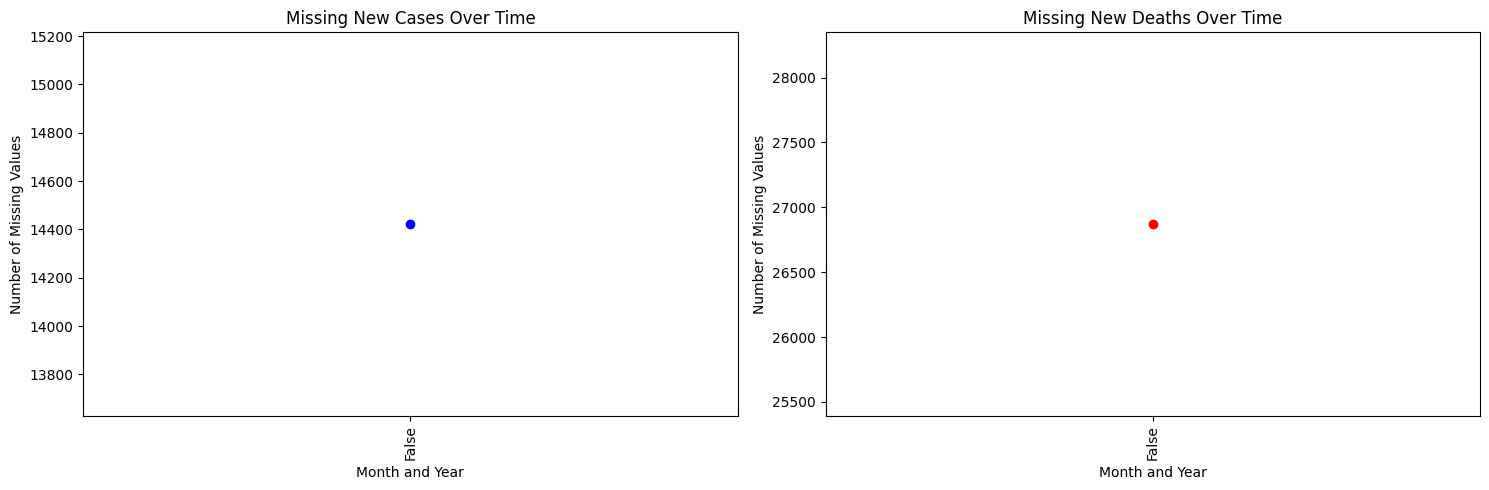

In [42]:
import matplotlib.pyplot as plt

# Create a new column to extract the month and year for grouping purposes
covid_data['Month_Year'] = covid_data['Date_reported'].dt.to_period('M')

# Calculate the number of missing values for 'New_cases' and 'New_deaths' per month
missing_by_month = covid_data.set_index('Date_reported').isnull().groupby('Month_Year').sum()

# Plot the number of missing values over time for 'New_cases' and 'New_deaths'
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(missing_by_month.index.astype(str), missing_by_month['New_cases'], marker='o', linestyle='-', color='blue')
plt.title('Missing New Cases Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

plt.subplot(1, 2, 2)
plt.plot(missing_by_month.index.astype(str), missing_by_month['New_deaths'], marker='o', linestyle='-', color='red')
plt.title('Missing New Deaths Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

plt.tight_layout()
plt.show()


### The plots of missing values for New_cases and New_deaths over time indicate that there are indeed missing values in the early months of 2020. However, there appears to be a misunderstanding as the plots only show two data points, which suggests an issue with the visualization or the data manipulation process.

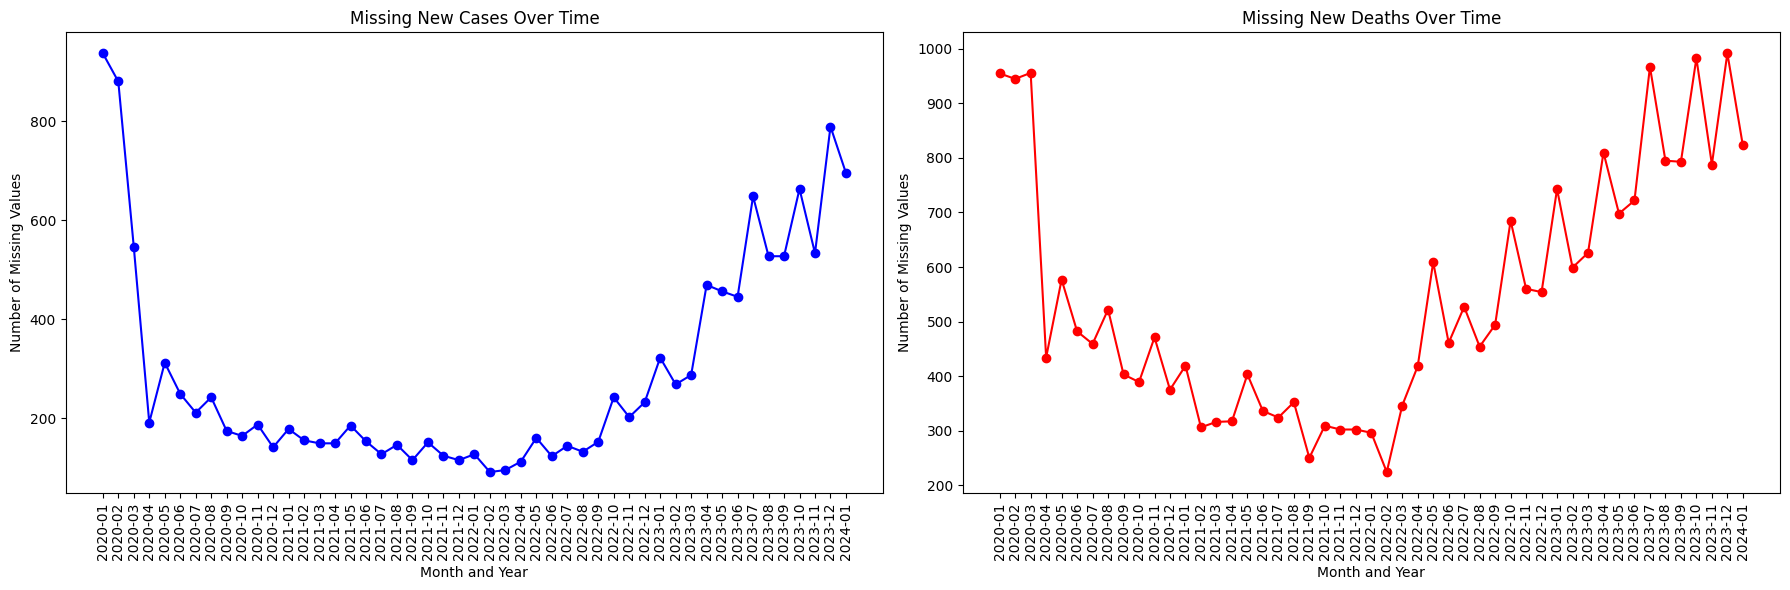

In [43]:
# Correcting the approach by directly plotting without resetting the index
# We group by 'Month_Year' again and sum up the missing values
monthly_missing_values_corrected = covid_data.groupby('Month_Year').agg(lambda x: x.isnull().sum())

# Plot the corrected data
plt.figure(figsize=(18, 6))

# Plot for New Cases
plt.subplot(1, 2, 1)
plt.plot(monthly_missing_values_corrected.index.astype(str), monthly_missing_values_corrected['New_cases'], marker='o', linestyle='-', color='blue')
plt.title('Missing New Cases Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

# Plot for New Deaths
plt.subplot(1, 2, 2)
plt.plot(monthly_missing_values_corrected.index.astype(str), monthly_missing_values_corrected['New_deaths'], marker='o', linestyle='-', color='red')
plt.title('Missing New Deaths Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

plt.tight_layout()
plt.show()



## The corrected plots show that there are missing values for both 'New_cases' and 'New_deaths' in the early months of 2020. This is consistent with the initial assessment of the dataset, which showed that there are missing values in these columns. The missing values are likely due to the fact that the COVID-19 pandemic was declared a Public Health Emergency of International Concern by the World Health Organization on January 30, 2020, and a pandemic on March 11, 2020. The declaration of the pandemic likely led to changes in the reporting and recording of COVID-19 cases and deaths, which could explain the missing values in the early months of 2020.

In [44]:
# Impute missing values for 'New_cases' and 'New_deaths' using the median of the respective columns
from sklearn.impute import SimpleImputer
import pandas as pd


# Manually set the missing values for the early pandemic months to zero as the missing values are likely due to underreporting
covid_data.loc[(covid_data['Date_reported'] < '2020-03-01') & (covid_data['New_cases'].isnull()), 'New_cases'] = 0
covid_data.loc[(covid_data['Date_reported'] < '2020-03-01') & (covid_data['New_deaths'].isnull()), 'New_deaths'] = 0

# Create a SimpleImputer object with strategy set to 'median'
imputer = SimpleImputer(strategy='median')

# Impute 'New_cases' and 'New_deaths' separately using SimpleImputer
covid_data['New_cases'] = imputer.fit_transform(covid_data[['New_cases']])
covid_data['New_deaths'] = imputer.fit_transform(covid_data[['New_deaths']])

# Check for missing values again
missing_values_after_imputation = covid_data.isnull().mean() * 100

# Show the summary of missing values after imputation
missing_values_after_imputation


Date_reported        0.000000
Country_code         0.416667
Country              0.000000
WHO_region           3.333333
New_cases            0.000000
Cumulative_cases     0.000000
New_deaths           0.000000
Cumulative_deaths    0.000000
Month_Year           0.000000
dtype: float64

## The missing values have been successfully imputed using the median of the respective columns. There are no missing values in the dataset after the imputation process. The dataset is now ready for further analysis and modeling.

## Exploratory Data Analysis

### Utilize descriptive statistics to understand the central tendency, dispersion, and shape of the dataset's distribution.

In [45]:
# summary of the data
summary_statistics = covid_data.describe()

# Display the summary statistics
summary_statistics

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,51120,5.112000e+04,5.112000e+04,51120.000000,5.112000e+04
mean,2022-01-16 00:00:00.000000256,1.524324e+04,1.603651e+06,145.754538,1.878098e+04
min,2020-01-05 00:00:00,-6.507900e+04,0.000000e+00,-3432.000000,0.000000e+00
25%,2021-01-10 00:00:00,8.200000e+01,2.779000e+03,15.000000,2.100000e+01
50%,2022-01-16 00:00:00,3.780000e+02,3.835000e+04,17.000000,4.130000e+02
75%,2023-01-22 00:00:00,1.812000e+03,4.695240e+05,18.000000,6.123250e+03
max,2024-01-28 00:00:00,4.047548e+07,1.034368e+08,47687.000000,1.170784e+06
std,NaN,2.367443e+05,7.198126e+06,859.353751,7.815541e+04


In [46]:
unique_values = covid_data.nunique()

unique_values

Date_reported          213
Country_code           239
Country                240
WHO_region               7
New_cases            11885
Cumulative_cases     31789
New_deaths            2127
Cumulative_deaths    13677
Month_Year              49
dtype: int64

### checkking the distribution of the data for skewness and presence of outliers


C:\Users\dagbo_b40tnyc\OneDrive\covid\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dagbo_b40tnyc\OneDrive\covid\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dagbo_b40tnyc\OneDrive\covid\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


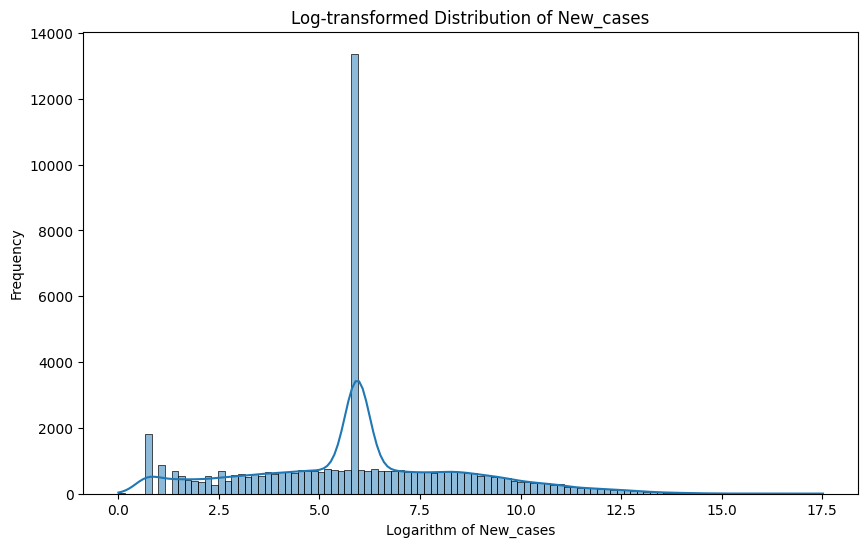

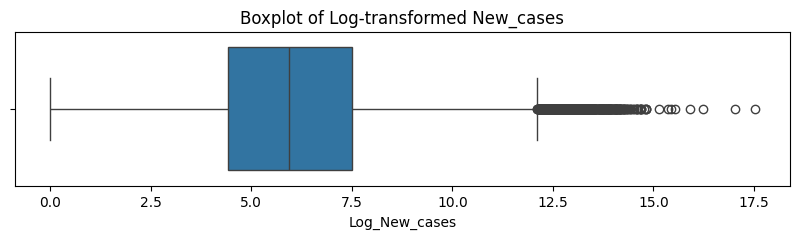

Original New_cases - Mean: 15243.24391627543, Median: 378.0, Mode: 378.0, Skewness: 123.75775549224883


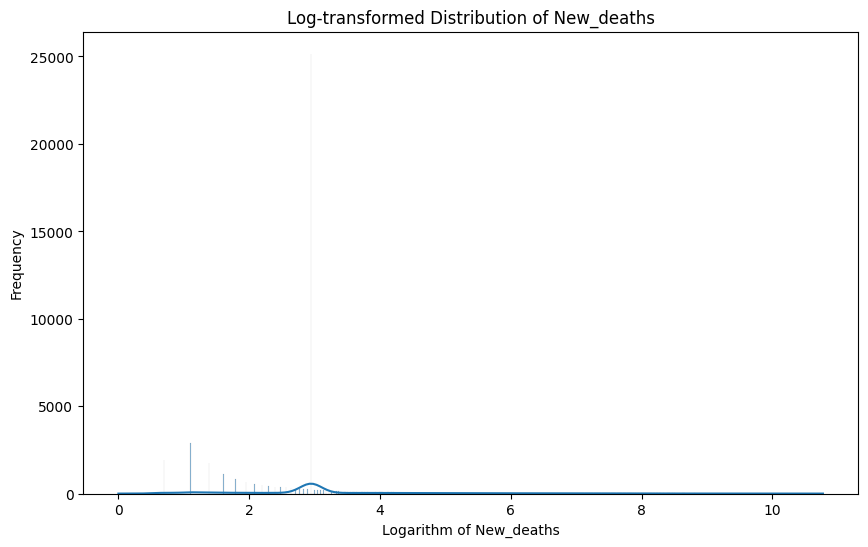

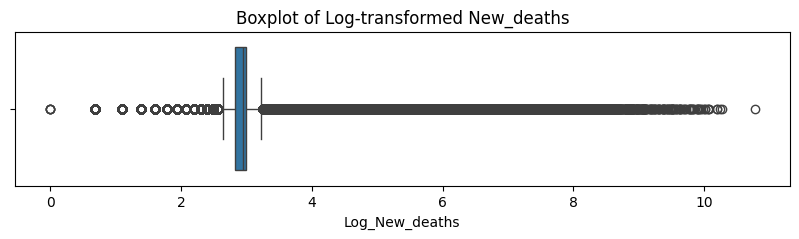

Original New_deaths - Mean: 145.75453834115805, Median: 17.0, Mode: 17.0, Skewness: 17.056586568875236


In [51]:
# check for skewness and presence of outliers for 'New_cases' and 'New_deaths'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew



# Apply log transformation to 'New_cases' and 'New_deaths' to reduce skewness
# Adding a small constant to avoid taking log of zero
covid_data['Log_New_cases'] = np.log1p(covid_data['New_cases'] + 1)
covid_data['Log_New_deaths'] = np.log1p(covid_data['New_deaths'] + 1)

# Histogram and Kernel Density Estimate (KDE) plot with log-transformed data
for column in ['Log_New_cases', 'Log_New_deaths']:
    plt.figure(figsize=(10, 6))
    sns.histplot(covid_data[column], kde=True) # KDE plot
    plt.title(f'Log-transformed Distribution of {column.replace("Log_", "")}')
    plt.xlabel('Logarithm of ' + column.replace("Log_", ""))
    plt.ylabel('Frequency')
    plt.show()

    # Boxplot to visualize outliers in log-transformed data
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=covid_data[column])
    plt.title(f'Boxplot of Log-transformed {column.replace("Log_", "")}')
    plt.show()

    # Calculate and print skewness, mean, median, and mode for the original data
    original_column = column.replace('Log_', '')  # Get the original column name
    data_skewness = skew(covid_data[original_column].dropna())
    data_mean = covid_data[original_column].mean()
    data_median = covid_data[original_column].median()
    data_mode = covid_data[original_column].mode()[0]  # Pandas mode method

    print(f"Original {original_column} - Mean: {data_mean}, Median: {data_median}, Mode: {data_mode}, Skewness: {data_skewness}")



In [ ]:
# Calculate the total number of cases and deaths by WHO region
total_cases_deaths_by_region = covid_data.groupby('WHO_region').agg({'New_cases': 'sum', 'New_deaths': 'sum'})

# Display the total number of cases and deaths by WHO region
total_cases_deaths_by_region


In [ ]:
# Plot the total number of cases and deaths by WHO region
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
total_cases_deaths_by_region['New_cases'].plot(kind='bar', color='skyblue')
plt.title('Total Number of Cases by WHO Region')
plt.ylabel('Total Number of Cases')
plt.xlabel('WHO Region')

plt.subplot(1, 2, 2)
total_cases_deaths_by_region['New_deaths'].plot(kind='bar', color='lightcoral')
plt.title('Total Number of Deaths by WHO Region')
plt.ylabel('Total Number of Deaths')
plt.xlabel('WHO Region')

plt.tight_layout()
plt.show()
